In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
prod_data = pd.read_csv('production_data.csv')
wells_data =  pd.read_csv('wellsData.csv')
op_aliasing_data = pd.read_csv('operator_aliasing.csv')

C:\Users\Dell\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# dropping unnecessary columns from tables
cols = ['API', 'Year', 'Month', 'Liquid', 'Gas', 'RatioGasOil']
prod_data = prod_data[cols]

cols = ['API', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

cols = ['Name', 'Alias']
op_aliasing_data = op_aliasing_data[cols]

In [5]:
# adding zeros to API
prod_data['API'] = (prod_data['API']).astype(str)
prod_data['API'] = prod_data['API'].apply(lambda x: x.zfill(14))

In [6]:
# renaming operators
alias_dict = dict(zip(op_aliasing_data.Name, op_aliasing_data.Alias))
wells_data['operatorNameIHS'] = wells_data['operatorNameIHS'].map(alias_dict).fillna(wells_data['operatorNameIHS'])

In [7]:
idx_max = prod_data.groupby(['API'])['Liquid'].transform('max') == prod_data['Liquid']
max_month_prod_data = prod_data[idx_max].drop_duplicates(subset='API', keep='first', inplace=False)
list_indices = ['API', 'Year', 'Month', 'Liquid']
max_month_prod_data = max_month_prod_data[list_indices]
max_month_prod_data = max_month_prod_data.rename(columns={"Year": "Max_Year", "Month": "Max_Month", "Liquid": "Max_Liquid"})

In [8]:
# merging the two dataframes to get max month and max year and removing rows with months =< peak_month
new_prod_data_orig = prod_data.merge(max_month_prod_data, on='API')

In [9]:
# Remove Pre-Peak Months (clean up)
new_prod_data = new_prod_data_orig[((new_prod_data_orig['Year'] == new_prod_data_orig['Max_Year']))]
new_prod_data = new_prod_data[((new_prod_data['Month'] >= new_prod_data['Max_Month']))]
new_prod_data2 = new_prod_data_orig[((new_prod_data_orig['Year'] > new_prod_data_orig['Max_Year']))]
new_prod_data3 = new_prod_data.append(new_prod_data2)

In [10]:
def calc_month_index(max_year, max_month, year, month):
    return (12 - max_month + (year - max_year - 1)*12 + month) * (year != max_year) + (year == max_year) * (month - max_month) + 1 

In [11]:
new_prod_data3['index'] = calc_month_index(new_prod_data3['Max_Year'], new_prod_data3['Max_Month'], new_prod_data3['Year'], new_prod_data3['Month'])
indexed_prod_data = new_prod_data3

# Problems encountered

## 1) 0 max liquid production, fixed by setting first month as peek month
## 2) missing months data in indexing months, fixed by super smart indexing equation
## 3) missing month data in plotting, will be fixed by moving average inshaAllah
## 4) UNKNOWN alias and operator


In [12]:
# TODO: disregard wells/basins? with less than 5 years production

In [13]:
wells_data_4basins = wells_data[wells_data['BasinName'] == 'DENVER BASIN']
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'PERMIAN BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'ANADARKO BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'WILLISTON BASIN'])
wells_data_4basins['API'] = wells_data_4basins['API'].astype(str)

In [14]:
indexed_wells_4basins = wells_data_4basins.merge(indexed_prod_data, on='API')

In [15]:
print(indexed_wells_4basins.groupby('BasinName'))
indexed_wells_4basins.groupby('index').mean()


,Year,Month,Liquid,Gas,RatioGasOil,Max_Year,Max_Month,Max_Liquid
index,,,,,,,,
1,2014.613520,6.619033,15428.412937,32365.166470,20.978464,2014.613520,6.619033,15456.562820
2,2014.646258,6.635406,10944.573153,28074.962165,34.558799,2014.568045,6.573960,15427.611918
3,2014.676946,6.731089,8761.499430,24687.468371,28.079652,2014.526205,6.539976,15330.812627
4,2014.724558,6.598955,7482.095690,22267.534810,22.997497,2014.481615,6.514266,15235.500502
5,2014.743331,6.690996,6509.327947,20386.148758,22.009226,2014.426081,6.497996,15095.724847
6,2014.773796,6.607593,5784.766053,18762.220045,27.492357,2014.366370,6.496713,14948.493361
7,2014.812368,6.502375,5200.973105,17320.187025,32.456917,2014.311655,6.510927,14824.089316
8,2014.830520,6.552731,4763.084202,16280.719173,37.538887,2014.248253,6.539938,14692.736105
9,2014.864379,6.443412,4372.063286,15234.442346,46.640951,2014.185675,6.587862,14552.775014


In [16]:
indexed_wells_4basins

,API,CompletionDate,operatorNameIHS,BasinName,Year,Month,Liquid,Gas,RatioGasOil,Max_Year,Max_Month,Max_Liquid,index
0,49021207420000,2011-07-01,NANKE ENERGY LLC,DENVER BASIN,2011,7,0,47,0.000000,2011,7,0,1
1,49021207420000,2011-07-01,NANKE ENERGY LLC,DENVER BASIN,2011,8,0,0,0.000000,2011,7,0,2
2,49021207420000,2011-07-01,NANKE ENERGY LLC,DENVER BASIN,2011,9,0,14,0.000000,2011,7,0,3
3,49021207420000,2011-07-01,NANKE ENERGY LLC,DENVER BASIN,2011,10,0,100,0.000000,2011,7,0,4
4,49021216140001,2015-09-01,KAISER-FRANCIS,DENVER BASIN,2016,1,4139,1627,0.393090,2016,1,4139,1
5,49021216140001,2015-09-01,KAISER-FRANCIS,DENVER BASIN,2016,2,3961,1101,0.277960,2016,1,4139,2
6,49021216140001,2015-09-01,KAISER-FRANCIS,DENVER BASIN,2016,3,3555,807,0.227004,2016,1,4139,3
7,49021216140001,2015-09-01,KAISER-FRANCIS,DENVER BASIN,2016,4,3848,1355,0.352131,2016,1,4139,4
8,49021216140001,2015-09-01,KAISER-FRANCIS,DENVER BASIN,2016,5,4111,1855,0.451228,2016,1,4139,5
9,49021216140001,2015-09-01,KAISER-FRANCIS,DENVER BASIN,2016,6,1728,1249,0.722801,2016,1,4139,6


In [131]:
def get_stats(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)]
    group_liquid = group["Liquid"]
    mean = group_liquid.mean()
    median = group_liquid.median()
    perct = group_liquid.quantile(.9)
    liquid = group_liquid
    return [[mean], [median], [perct], liquid]

def mean_basin(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group["Liquid"].mean()

def median_basin(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group["Liquid"].median()

def percentile(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group["Liquid"].quantile(.9)

def liquid(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group['Liquid']




In [132]:
pre2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] < '2014-01-01']
post2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] >= '2014-01-01']
indices = np.arange(36) + 1
basins = ["ANADARKO BASIN","DENVER BASIN", "PERMIAN BASIN", "WILLISTON BASIN"]

all_stats_pre = np.array([[get_stats(y, x, pre2014) for x in indices] for y in basins]) 
all_stats_post = np.array([[get_stats(y, x, post2014) for x in indices] for y in basins]) 

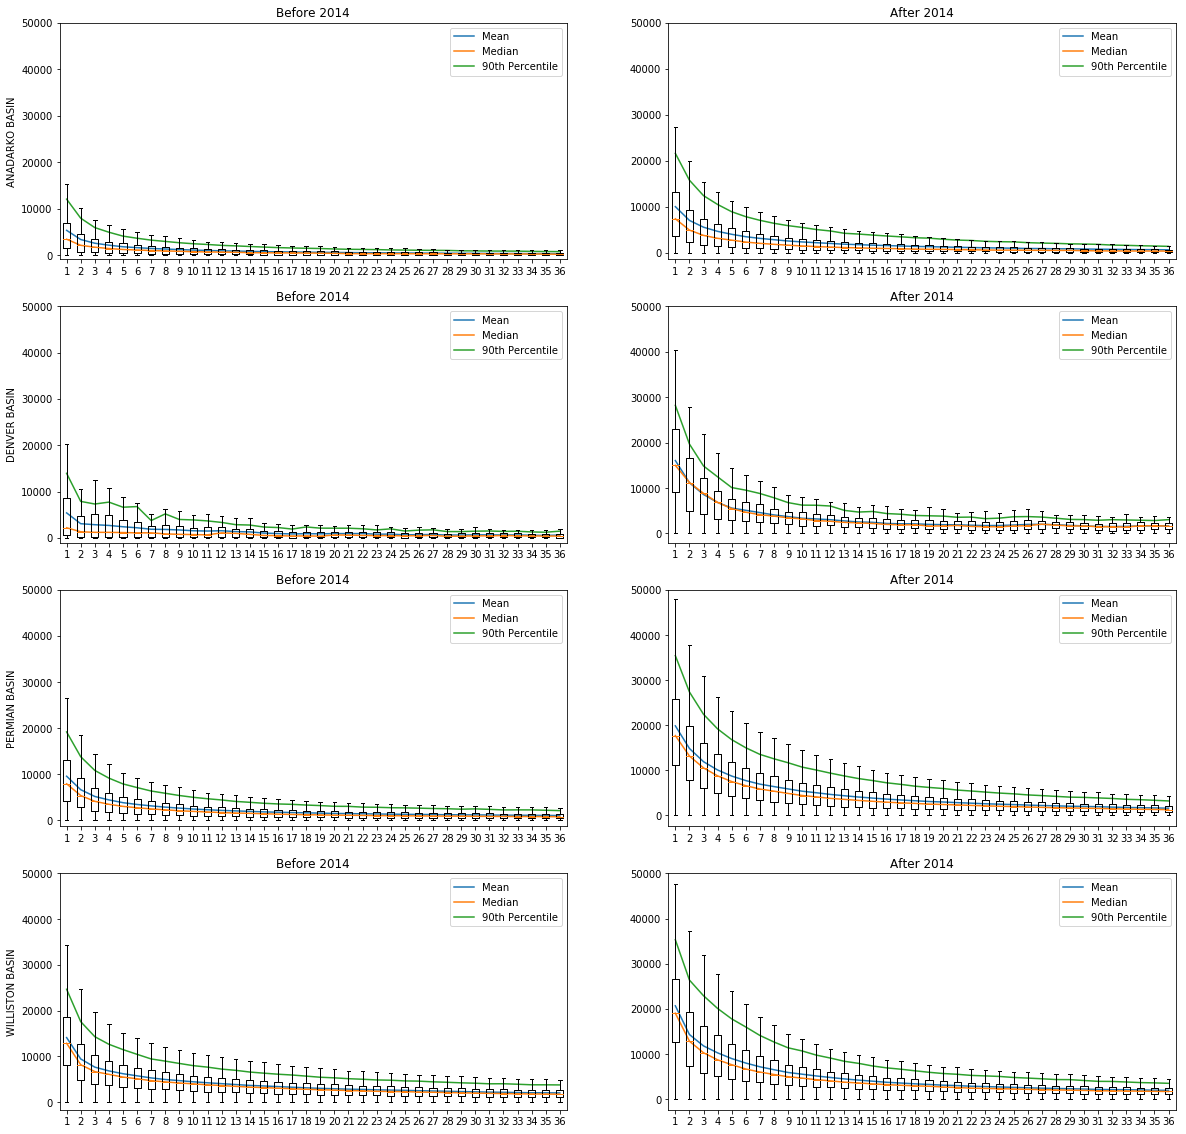

In [129]:
plt.rcParams["figure.figsize"]=20,20

idx = 1
for i in range(len(basins)):

    ax1 = plt.subplot(4,2,idx)
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,0]), label="Mean")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,1]), label="Median")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,2]), label="90th Percentile")
    ax1.boxplot(list(all_stats_pre[i,:,3]), showfliers=False)
    ax1.set_ylim(top=50000)
    ax1.legend()
    ax1.set_title('Before 2014')
    ax1.set_ylabel(basins[i])
    idx += 1

    ax2 = plt.subplot(4,2,idx)
    ax2.plot(indices, np.hstack(all_stats_post[i,:,0]), label="Mean")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,1]), label="Median")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,2]), label="90th Percentile")
    ax2.boxplot(list(all_stats_post[i,:,3]), showfliers=False)
    ax2.set_ylim(top=50000)
    ax2.set_title('After 2014')
    ax2.legend()
    
    idx += 1



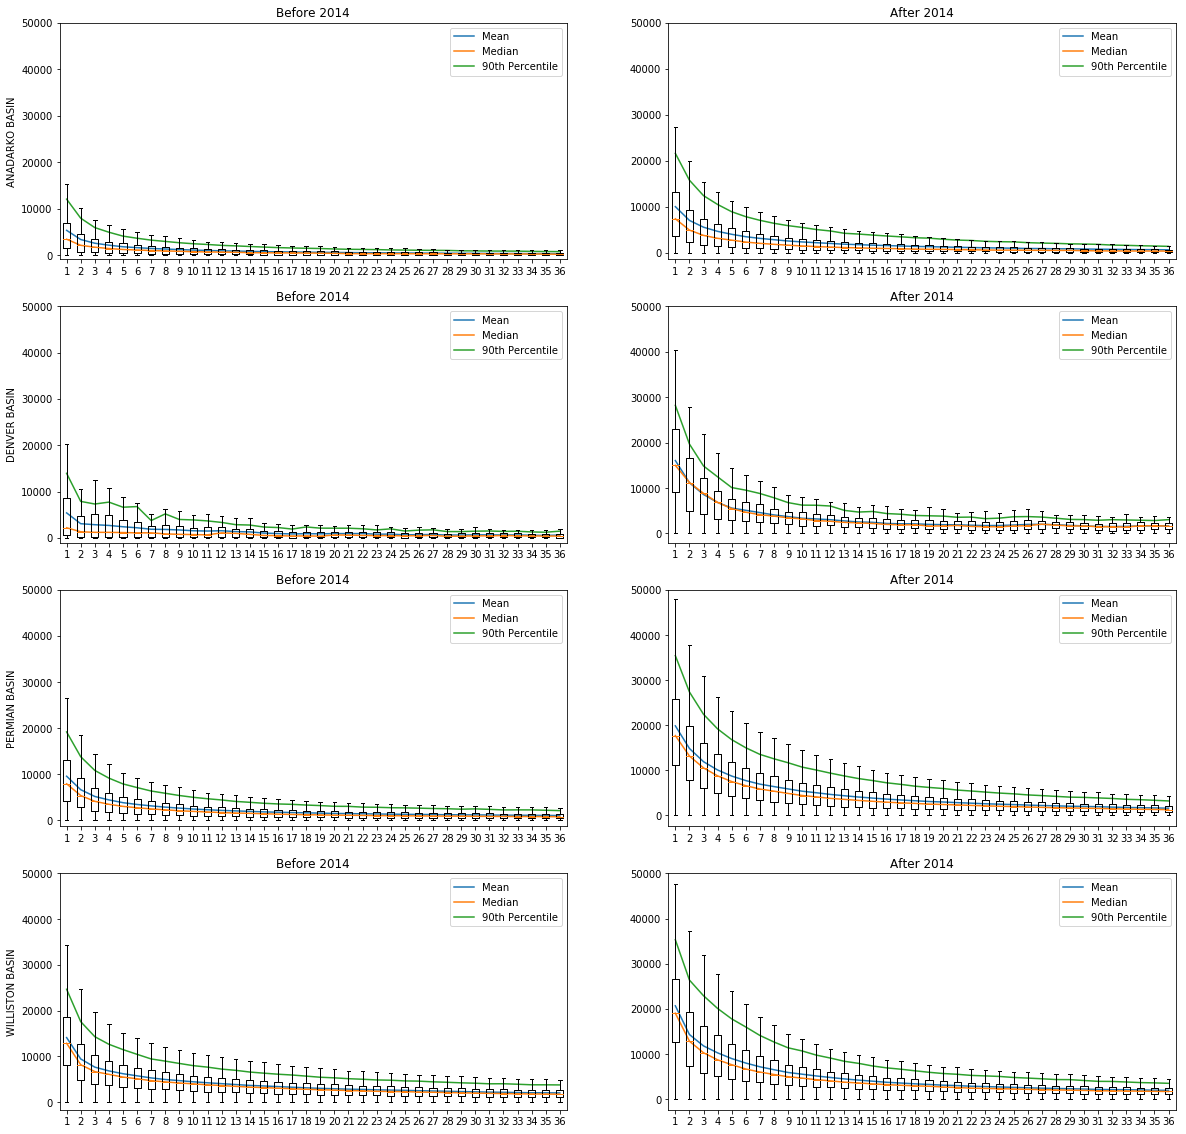

In [125]:
plt.rcParams["figure.figsize"]=20,20

idx = 1
for i in range(len(basins)):

    ax1 = plt.subplot(4,2,idx)
    ax1.plot(indices, means_pre[i], label="Mean")
    ax1.plot(indices, medians_pre[i], label="Median")
    ax1.plot(indices, percentiles_pre[i], label="90th Percentile")
    ax1.boxplot(liquid_pre[i], showfliers=False)
    ax1.set_ylim(top=50000)
    ax1.legend()
    ax1.set_title('Before 2014')
    ax1.set_ylabel(basins[i])
    idx += 1

    ax2 = plt.subplot(4,2,idx)
    ax2.plot(indices, means_post[i], label="Mean")
    ax2.plot(indices, medians_post[i], label="Median")
    ax2.plot(indices, percentiles_post[i], label="90th Percentile")
    ax2.boxplot(liquid_post[i], showfliers=False)
    ax2.set_ylim(top=50000)
    ax2.set_title('After 2014')
    ax2.legend()
    
    idx += 1

